# Model building: Linear Regression

For the anxiety dataset, the target variable is Anxiety Level (1-10), which is an ordinal numeric variable. I will treat it as a numerical variable during modeling, and in this case I will focus on 3 different models:

* **Linear regression**
* **Random Forest**
* **XGBoost**

In the feature engineering stage, numerical columns were standardized, and categorical columns one-hot encoded. The data was split into training and test set, and the evaluation will be performed on the test set. So far, I chose not to make a separate validation set or perform cross-validation, as I will do this step to ensure consistency in the model tuning and evaluation stage. 


In the previous stages, some variables such as Stress Level, Sleep Hours, Therapy Sessions and Caffeine Intake showed high linear correlation with anxiety levels. This suggests that Linear Regression might be an appropriate model for this dataset. There are 2 implementations of linear regression in Python: using **statsmodels** and **scikit-learn (sklearn)** packages. Both statsmodels and scikit-learn implement **Ordinary Least Squares Regression (OLS)** which minimizes the sum of squared differences between the observed and predicted values.

**Statsmodels** gives a variety of useful metrics in its output, such as p-values, confidence intervals, $R^2$ and adjusted $R^2$. Scikit-learn doesn't provide such details, hence statsmodels implementation is useful for early model diagnostics. Thus, I will first use statsmodels to get an initial feel for how my linear model behaves and what predictors are the most influential. The disadvantage of this package for regression is that interaction terms have to be inserted manually, which becomes tedious for a large number of predictor variables.

On the other hand, **scikit-learn** is better integrated with other ML libraries, and I will focus on actually building a model using sklearn after running initial diagnostics. In addition, adding interaction terms in sklearn is easy, because there is a function `PolynomialFeatures` that handles interactions automatically after specifying the degree of the polynomial. Unlike regression in statsmodels, it is focused more on predictive power than on statistical inference.



For evaluating the performance of my model, I will use the **root mean squared error (RMSE)** metric. This is my choice of metric because it penalizes larger errors more than smaller ones (due to the squaring the errors in the equation), and taking the root of the **mean squared error (MSE)** ensures that the RMSE in the same units as the target variable. In addition, I will calculate the **$R^2$ coefficient of determination**, which tells me what percentage of variability in my data is explained by the model. **Adjusted $R^2$** penalizes the model to account for the addition of predictors that do not improve the model performance. Lower RMSE and higher $R^2$ indicate a better model performance.

I will also construct a **baseline model**, which is a model that always predicts the mean value of the target variable, so I can use it as a benchmark for comparison with other models. If the RMSE is lower for linear regression model than for a baseline, then there is improvement in predictive power and the model should be kept.

Finally, after fitting the model and evaluating the results, in order do confirm the validity of the model I have to check **model assumptions**. For linear regression, these are: **linearity**, **normality of residuals**, **homoscedasticity** and **no multicolinearity**. If all of these assumptions are fullfilled, the model is valid.


I will first import all the necessary libraries and datasets.

In [122]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [123]:
anxiety_data = pd.read_csv("enhanced_anxiety_dataset.csv")
X_train_final = pd.read_csv("X_train_final.csv")
X_test_final = pd.read_csv("X_test_final.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

X_train_final.columns

Index(['Age', 'Sleep Hours', 'Physical Activity (hrs/week)',
       'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)',
       'Stress Level (1-10)', 'Heart Rate (bpm)',
       'Breathing Rate (breaths/min)', 'Sweating Level (1-5)',
       'Therapy Sessions (per month)', 'Diet Quality (1-10)',
       'Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour',
       'Gender_Male', 'Gender_Other', 'Occupation_Athlete', 'Occupation_Chef',
       'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Freelancer',
       'Occupation_Lawyer', 'Occupation_Musician', 'Occupation_Nurse',
       'Occupation_Other', 'Occupation_Scientist', 'Occupation_Student',
       'Occupation_Teacher', 'Smoking_Yes', 'Family History of Anxiety_Yes',
       'Dizziness_Yes', 'Medication_Yes', 'Recent Major Life Event_Yes'],
      dtype='object')

### Linear Regression using statsmodels


In the EDA and statistical testing stages I identified that the features with the highest linear correlation with anxiety levels are **Stress Level** and **Sleep hours**, followed by **Therapy Sessions (per month)** and **Caffeine Intake (mg/day)**. However, feature engineering stage showed that their combination **Stress Level per Sleep Hour**, representing the level of stress per hour of sleep, had a higher mutual information (MI) score than these predictors individually. Since MI captures both linear and nonlinear relationships with the target, I will explore how the model performs first taking individual features as a predictor, and then their combination, with all of the other features. Additionally, since MI showed very little difference in score between **Therapy Sessions** and it's logarithm **Log Therapy Sessions**, I will drop the latter column from the dataset.

First, I will train a model using **Stress Level** and **Sleep hours** predictors, and then I will use **Stress Level per Sleep Hour** variable instead. From the feature egineering stage, for categorical variables, the baseline category for Occupation is 'Artist', and for Gender is 'Female'. For binary categorical variables, the baseline category is the one where individuals answered 'No'.

In [60]:
X_train_sm1_temp = X_train_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour']).copy()
y_train_sm1 = y_train.copy()

# add an intercept term
X_train_sm1 = sm.add_constant(X_train_sm1_temp)

# fit the ordinary least regression
model_sm1 = sm.OLS(y_train_sm1, X_train_sm1)
results_sm1 = model_sm1 .fit()

# print the summary
print(results_sm1.summary())

                             OLS Regression Results                             
Dep. Variable:     Anxiety Level (1-10)   R-squared:                       0.720
Model:                              OLS   Adj. R-squared:                  0.719
Method:                   Least Squares   F-statistic:                     749.9
Date:                  Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                          10:15:39   Log-Likelihood:                -13510.
No. Observations:                  8800   AIC:                         2.708e+04
Df Residuals:                      8769   BIC:                         2.730e+04
Df Model:                            30                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

Overall, the F-statistic has a value of $749.9$, and the p-value is very small, indicating that this model is statistically significant. The $R^2$ and adjusted $R^2$ are around $0.72$, indicating that $72 \%$ of the variability in the data is explained by the model. **AIC** (Akaike Information Criterion) and **BIC** (Bayesian Information Criterion) are both measures of model quality that balance goodness of fit and model complexity, however they are not useful on their own, only when comparing the values with other models. Generally, lower AIC and BIC indicate a better model.


The strongest linear predictor is Stress Level, with a regression coefficient $\beta_{Stress \ Level} = 1.11$, followed by Sleep Hours with $\beta_{Sleep \ Hours} = -0.5380$,  Therapy Sessions with $\beta_{Therapy \ sessions} =0.5361$ and Caffeine Intake with $\beta_{Caffeine \ Intake} =0.4308$. For Occupation, the baseline category is Artist, and if I chose a significance level of $\alpha = 0.01$ ($1$ percent), then for $p-value \ <\alpha$ statistically significant predictors would be Doctor, Engineer, Scientist and Lawyer, who seem to have lower anxiety levels than Artist. Although for raw data Artists appear less anxious on average than Lawyers, Doctors, Engineers, and Scientists, which was seen by taking the means of the column grouped by Occupation, after accounting for all other predictors Artists seem to have higher anxiety levels than these occupations.


Now, I will do the similar code taking the **Stress Level per Sleep Hour** variable instead.

In [14]:
X_train_sm2_temp = X_train_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level (1-10)', 'Sleep Hours']).copy()
y_train_sm2 = y_train.copy()

# add an intercept term
X_train_sm2 = sm.add_constant(X_train_sm2_temp)

# fit the ordinary least regression
model_sm2 = sm.OLS(y_train_sm2, X_train_sm2)
results_sm2 = model_sm2 .fit()

# print the summary
print(results_sm2.summary())

                             OLS Regression Results                             
Dep. Variable:     Anxiety Level (1-10)   R-squared:                       0.726
Model:                              OLS   Adj. R-squared:                  0.726
Method:                   Least Squares   F-statistic:                     803.0
Date:                  Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                          20:46:19   Log-Likelihood:                -13401.
No. Observations:                  8800   AIC:                         2.686e+04
Df Residuals:                      8770   BIC:                         2.707e+04
Df Model:                            29                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

The regression coefficient is larger for **Stress Level per Sleep Hour** that these predictors alone, because this variable combination now captures both high stress and low sleep in one term. The $R^2$ and adjusted $R^2$ increased from $0.72$ for the first model to $0.73$ for this model, and also both AIC and BIC decreased slighly, indicating that the model performs slightly better. However, this combination of features didn't drastically improve the model, so either of these predictor choice still makes up for a good model. Occupations like Engineer, Lawyer, Scientist and Doctor remain statistically significant for this model.

### Linear Regression using scikit-learn

As stated previously, `LinearRegression` from sklearn integrates better with pipelines, feature engineering and cross validation. It is also easy to add interaction terms using `PolynomialFeatures`, whereas in statsmodels this has to be done manually. From previous stages of the analysis, there was a hint that there are some useful interaction terms. Hence, I will do the same models as before, just using a different package for this case. For convenience, I will use a **pipeline** to both generate interaction terms and apply linear regression.

In [125]:
X_train_sk1 = X_train_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour']).copy()
X_test_sk1 = X_test_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour']).copy()


# generate interaction terms and initialize the model in a pipeline
interaction_model1 = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)),  
                              ('lr', LinearRegression())])

# fit the model (using the pipeline)
interaction_model1.fit(X_train_sk1, y_train)

# predict on the both training and test set
y_pred_train1 = interaction_model1.predict(X_train_sk1)
y_pred_test1 = interaction_model1.predict(X_test_sk1)

# evaluate on a training set
rmse_train1 = np.sqrt(mean_squared_error(y_train, y_pred_train1))
r2_train1 = r2_score(y_train, y_pred_train1)

# evaluate on a test set
rmse_test1 = np.sqrt(mean_squared_error(y_test, y_pred_test1))
r2_test1 = r2_score(y_test, y_pred_test1)

# compare results
print("Interaction model results (separate predictors):")
print(f"Train RMSE: {rmse_train1:.2f}")
print(f"Train R²: {r2_train1:.4f}")
print(f"Test RMSE: {rmse_test1:.2f}")
print(f"Test R²: {r2_test1:.4f}")

Interaction model results (separate predictors):
Train RMSE: 1.02
Train R²: 0.7670
Test RMSE: 1.08
Test R²: 0.7409


The score is better on the training set, which is expected: $76.5 \%$ of the variance of the data is explained by this model, and RMSE has a value of $1.03$ on the training set. On the test set, RMSE is $1.08$, while $R^2$ is about $74 \%$. This means that the model generalizes well, since the difference between the results is small. This is suprising since I kept all the relevant predictors, which could have lead to a minor overfitting, however the model appears to be generalizing well.

Again, taking the Stress Level per Sleep Hour as a predictor instead, I would get the following:

In [126]:
X_train_sk2 = X_train_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level (1-10)', 'Sleep Hours']).copy()
X_test_sk2 = X_test_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level (1-10)', 'Sleep Hours']).copy()


# generate interaction terms and initialize the model in a pipeline
interaction_model2 = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)),  
                              ('lr', LinearRegression())])

# fit the model (using the pipeline)
interaction_model2.fit(X_train_sk2, y_train)

# predict on the both training and test set
y_pred_train2 = interaction_model2.predict(X_train_sk2)
y_pred_test2 = interaction_model2.predict(X_test_sk2)

# evaluate on a training set
rmse_train2 = np.sqrt(mean_squared_error(y_train, y_pred_train2))
r2_train2 = r2_score(y_train, y_pred_train2)

# evaluate on a test set
rmse_test2 = np.sqrt(mean_squared_error(y_test, y_pred_test2))
r2_test2 = r2_score(y_test, y_pred_test2)

# compare results
print("Interaction model results (combined predictors):")
print(f"Train RMSE: {rmse_train2:.2f}")
print(f"Train R²: {r2_train2:.4f}")
print(f"Test RMSE: {rmse_test2:.2f}")
print(f"Test R²: {r2_test2:.4f}")

Interaction model results (combined predictors):
Train RMSE: 1.03
Train R²: 0.7629
Test RMSE: 1.08
Test R²: 0.7410


For this model, the performance is almost the same, with $R^2$ explaining $76.7 \%$ of the first and $76.3 \%$ of the second model's variability in the data. RMSE is the same on the test set, $1.08$ for both models, however on the training set the RMSE increased slightly from $1.02$ to $1.03$. This indicates that the model with combined features performed worse than the model where Stress Level and Sleep Hours were kept separate. Note that the models still perform almost identically, and this is a very small difference in metric values, so any choice for the model would be appropriate.

So far, considering that combining these 2 features into one, and log-transforming therapy sessions didn't yield significant improvements in the model, for linear regression I will stick to original data features, as it makes model interpretability easier.

In order to get all coefficients, including interaction terms, for the first model (which performed better), I will extract the coefficients and the intercept to inspect the feature combinations which contribute the most to anxiety.

In [64]:
# turn 2D array into 1D array 
coefficients = lr_model.coef_.ravel()

# exclude the bias term
feature_names_without_bias = feature_names[1:]

# make feature-coef pairs
feature_coef_pairs = list(zip(feature_names_no_bias, coefficients))

# sort by the absolute value of the coefficients
feature_coef_pairs_sorted = sorted(feature_coef_pairs, key=lambda x: abs(x[1]), reverse=True)


# Print results
for name, coef in feature_coef_pairs_sorted[:31]:
    print(f"{name}: {coef:.4f}")


Heart Rate (bpm): 1.1006
Caffeine Intake (mg/day) Occupation_Freelancer: -0.6534
Caffeine Intake (mg/day) Occupation_Student: -0.5872
Caffeine Intake (mg/day) Occupation_Musician: -0.5563
Caffeine Intake (mg/day) Occupation_Engineer: -0.5402
Alcohol Consumption (drinks/week): 0.5355
Occupation_Engineer Dizziness_Yes: -0.5089
Occupation_Lawyer Dizziness_Yes: -0.4534
Occupation_Doctor Dizziness_Yes: -0.4470
Gender_Other Occupation_Lawyer: -0.3698
Occupation_Freelancer Dizziness_Yes: -0.3441
Occupation_Teacher Dizziness_Yes: -0.3399
Therapy Sessions (per month) Occupation_Engineer: 0.3392
Caffeine Intake (mg/day) Occupation_Teacher: -0.3371
Occupation_Athlete Dizziness_Yes: -0.3189
Physical Activity (hrs/week): -0.3131
Caffeine Intake (mg/day) Occupation_Other: -0.3130
Gender_Other Occupation_Engineer: -0.3001
Gender_Other Occupation_Chef: -0.2823
Occupation_Scientist Dizziness_Yes: -0.2816
Caffeine Intake (mg/day) Occupation_Doctor: -0.2672
Occupation_Lawyer Recent Major Life Event_Yes: 

Now that the interaction terms are included in the model, the most useful predictors changed: now the top predictor is Heart Rate with coefficient $1.1006$, followed by interaction between Caffeine Intake  and occupations like Freelances, Student, Engineer and Musician with coefficients $-0.65$ to $-0.54$, then Alcohol consumption with $0.5355$ etc. Finally, I will check if the model with original features and no interaction terms can perform better that this model with polynomial terms.

In [127]:
X_train_sk3 = X_train_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour']).copy()
X_test_sk3 = X_test_final.drop(columns = ['Log Therapy Sessions (per month)', 'Stress Level per Sleep Hour']).copy()


# no interaction terms for this model
model3 = LinearRegression()

# fit the model (using the pipeline)
model3.fit(X_train_sk3, y_train)

# predict on the both training and test set
y_pred_train3 = model3.predict(X_train_sk3)
y_pred_test3 = model3.predict(X_test_sk3)

# evaluate on a training set
rmse_train3 = np.sqrt(mean_squared_error(y_train, y_pred_train3))
r2_train3 = r2_score(y_train, y_pred_train3)

# evaluate on a test set
rmse_test3 = np.sqrt(mean_squared_error(y_test, y_pred_test3))
r2_test3 = r2_score(y_test, y_pred_test3)

# compare results
print("Non-interaction model results:")
print(f"Train RMSE: {rmse_train3:.2f}")
print(f"Train R²: {r2_train3:.4f}")
print(f"Test RMSE: {rmse_test3:.2f}")
print(f"Test R²: {r2_test3:.4f}")

Non-interaction model results:
Train RMSE: 1.12
Train R²: 0.7195
Test RMSE: 1.12
Test R²: 0.7228


In [75]:
# make a dataframe for comparison
model_comparison = pd.DataFrame({
    "Metric": ["Train RMSE", "Train R²", "Test RMSE", "Test R²"],
    "No Interactions": [1.12, 0.7195, 1.12, 0.7228],
    "With Interactions": [1.02, 0.7670, 1.08, 0.7409]
})

# print results
model_comparison

,Metric,No Interactions,With Interactions
0,Train RMSE,1.1200,1.0200
1,Train R²,0.7195,0.7670
2,Test RMSE,1.1200,1.0800
3,Test R²,0.7228,0.7409


For the non-interacting model RMSE on the training set is $1.12$, compared to the interaction model with RMSE $1.02$. On the training set, the RMSE rose to $1.12$ comapred to the previous $1.08$. The $R^2$ coefficient fell to $0.72$ for both sets, meaning it explains less variability in the data compared to the interaction model.

In summary, including interaction terms of the second order improves model performance, yielding lower RMSE value and higher $R^2$ for both training and test set. Since the difference in RMSE for a training and test set is small, $1.08 - 1.02 = 0.06$, the model doesn't overfit the data, even though all predictors from the data are included. On the other hand, non-interacting model is simpler and more interpretable, but explains less variability and has lower predictive accuracy. Therefore, the interaction model captures important interaction terms that the non-interaction model misses.

### Comparison with the baseline model

I quickly want to compare my linear regression model to the **baseline model**, i.e. the model that would always predict the mean value.

In [128]:
# the code that always predicts a mean value

baseline_pred = np.full_like(y_test, y_test.mean()) 
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f'Baseline RMSE (test set): {baseline_rmse:.2f}')

Baseline RMSE (test set): 2.13


The **baseline** RMSE is $2.13$, which means that the prediction a baseline model makes is a bit over $2$ points, keeping in mind that anxiety is measured on a scale $1$ to $10$. Since the RMSE for the **interacting model** is $1.08$ on the test set, which is almost two times lower than the RMSE for the baseline model, the conclusion is that there is a significant improvement in prediction power.

## Checking Linear Regression Assumptions

**Linear regression model assumptions** and how to check them:
* **Linearity**: scatter plot, or fitted values vs. residuals plot
* **Normality of residuals**: histogram of residuals or Q-Q plot
* **Homoscedasticity**: fitted values vs. residuals plot
* **No multicollinearity**: Variance Inflation Factor (VIF)

Linearity has already been checked in the previous stages, and it was confirmed that the most useful predictors (columns) in the data have linear relationship with anxety level. Even after including interaction terms, according to the model results there is still linearity for these new, combined features. Hence, I will not explicitly check linearity.

Assumptions are evaluated on the training set, because it's where model has been trained, and the test set was used just for model evaluation.

### Normality of residuals

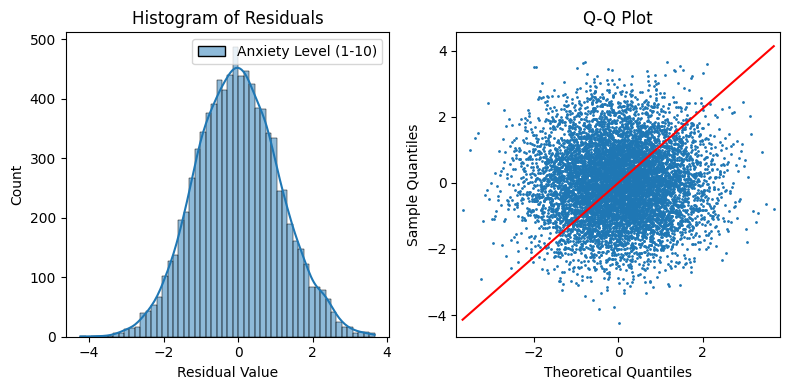

In [91]:
# calculate residuals on the training set
residuals_train = y_train - y_pred_train1

# create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))

# create a histogram of residuals
sns.histplot(residuals_train, ax=axes[0], kde=True)
axes[0].set_xlabel("Residual Value")
axes[0].set_title("Histogram of Residuals")

# create a Q-Q plot of the residuals
sm.qqplot(residuals_train, line='s',ax = axes[1], markersize=1)
axes[1].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

From the histogram, the residuals have a normal distribution, meaning that this condition is fullfilled for linear regression. Since there are lots of non-zero interaction terms in the model, the Q-Q plot has a shape of a cloud rather than a line, which makes it unreliable to determining the residuals normality. Hence, based on the histogram, the **normality of residuals assumption is fullfulled for the interacting linear model**.

### Homoscedasticity (constant variance of residuals)



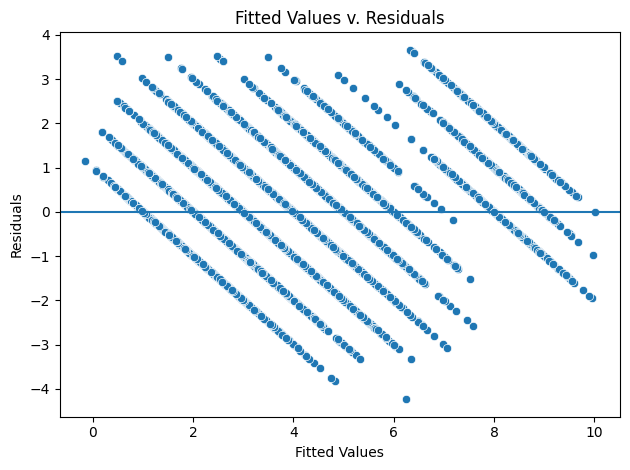

In [110]:
# plot the fitted values vs residuals
sns.scatterplot(x = y_pred_train1.flatten(), y = residuals_train.to_numpy().flatten())
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values v. Residuals")
plt.axhline(0)  # helps with the visualization below and above 0
plt.tight_layout()
plt.show()

The target variable Anxiety Level is an ordinal variable. Therefore, it is likely why these diagonal lines occur instead of a cloud, like for numeric continuous data. Although there is perhaps a pattern in this plot, I find it to be rather small, hence I would say that the **homoscedasticity assumption is also fulfilled**. 

### Multicolinearity check

Mutually correlated predictors lead to unstable and misleading regression coefficients for the data. I will use **Variance Inflation Factor (VIF)** to check multicolinearity. VIF measures how much a feature’s variance is inflated due to multicollinearity with other features, so the choice of predictors affects the results. For VIF between values $1$ and $10$ are considered acceptable, with values greater than $5$ slightly concerning. Predictors with values greater than $10$ should be handled by removing them, or combining them with correlated features. In addition, using regularization techniques such as **Lasso**, **Ridge** or **ElasticNet** can reduce impact of colinearity between predictors.

In [114]:
# calculate the VIF
vif = [variance_inflation_factor(X_train_sk1.values, i) for i in range(X_train_sk1.shape[1])]    # calculate VIF for each variable in X

# convert to a dataframe
df_vif = pd.DataFrame(vif, index=X_train_sk1.columns, columns = ['VIF'])  
df_vif

,VIF
Age,1.063206
Sleep Hours,1.268212
Physical Activity (hrs/week),1.072281
Caffeine Intake (mg/day),2.075039
Alcohol Consumption (drinks/week),1.011769
Stress Level (1-10),1.082526
Heart Rate (bpm),1.050024
Breathing Rate (breaths/min),1.036334
Sweating Level (1-5),1.032417
Therapy Sessions (per month),1.671595


Since most features have VIF value $<2$, with a few having up to $3$, I conclude that **there is no multicolinearity in the data**.



## Key Takeaways

* The linear regression models were first built in **statsmodels**, for initial diagnostics, without interaction terms, to explore how individual features contribute to the anxiety level prediction.
* The models were re-built in **scikit-learn**, with **polynomial terms** ($n=2$) added for interactions between features, in hopes of capturing more complex relationship in the data.
* The **Log Therapy Sessions** or **Stress Level per Sleep Hour** variables didn't lead to a meaningful improvement of model performance, so the original features were kept for modeling purposes.
* The **model without interaction terms** had RMSE of $1.12$ on both training and test set, and about $72 \%$ of variance in the data explained. This model was then compared with the one including feature interactions.
* The **model containing interaction terms** performed better than the one with just the feature columns itself, with RMSE of $1.08$ on the test set and $1.02$ on the training set. In addition, the coefficient of determination $R^2$ explained almost $77 \%$ of the variability for the training data, and about $74 \%$ for the test data. Hence, this is the **best performing linear model**, since it has higher $R^2$ and lower RMSE than the model without interactions. There is no overfitting on the test set - a suprising result considering that all predictors were included during in the model.
* The **interaction model** is almost twice as accurate as the **baseline model**, representing significant improvement in prediction. With the baseline RMSE of $2.13$, reduction to $1.08$ for the interaction model represents a significant improvement for predictions.
* Checked **linear regression assumptions** (reporting for the best model):
    * **Linearity**: there are linear relationships in the data
    * **Normality of residuals**: the residuals  were approximatelly normally distributed, confirmed with a histogram of residuals and a Q-Q plot
    * **Homoscedasticity**: the residuals showed somewhat constant variance, confirmed with residuals vs. fitted values plot.
    * **No multicollinearity**: there were no multicolinearity issues between predictors, confirmed by variance inflation factor (all values less than $3$).

In conclusion, the interaction model is the best valid model, and makes predictions within approximatelly $1$ point, on average, for the Anxiety Level. This represents a **relative error of $10 \%$ for the interaction model**, considering that anxiety takes values $1$ to $10$, which is significantly better than the **relative error** of more than **$20 \%$ ($2$ points) for a baseline model**.

**Next steps**:
* Explore more sophisticated models, such as **Random Forest** and **XGBoost**, with the goal of achieving better predictive power.
* Further tune the linear regression model by experimenting with different choices of features, with minimal loss to the predictive power. This makes the model more robust to missing data and also more interpretable. *Note: if other models perform much better than linear regression in the model building stage, this step will not be necessary, as more advanced models will offer equal or better performance when tuned.*


